In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cbook as cbook
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
sns.set_style("whitegrid")
#sns.set()

In [2]:
# our results
replication_results = pd.read_csv('results_rf_default.csv', index_col=0, )
replication_results.reset_index(inplace=True)
replication_results['experiment'] = 'replication_results'
replication_results
replication_results.columns = ['simulation', 'N', 'TRF', 'SRF', 'XRF_True', 'XRF', 'experiment']
replication_results = pd.melt(replication_results, id_vars=['experiment', 'simulation', 'N'],
                              value_vars=['XRF', 'SRF', 'TRF', 'XRF_True'], 
                              var_name='metalearner', 
                              value_name='mse')

In [3]:
# author results

# initialize master df
author_repo_results=pd.DataFrame()

# set up dictionary that maps our sim names to author repo sim names
sim_dict = {'simA':'unbalanced_treatment',
          'simB':'complex_linear',
          'simC': 'complex_nonlinear',
          'simD': 'beta_confounded'}

# reach in each sim from author repo and concatenate so schema is the same as our results df
for sim_letter, sim_description in sim_dict.items():
    url = 'https://raw.githubusercontent.com/theo-s/metalearners-reproduction/main/code/Appendix/results/'+sim_description+'EMSE.csv'
    df = pd.read_csv(url)
    
    # add our sim name
    df['simulation'] = sim_letter
    
    # drop BART columns since we did not use that base learner
    cols = [c for c in df.columns if c[1:] != 'BART']
    df = df[cols]
    
    # append each sim to master df
    author_repo_results = pd.concat([author_repo_results, df])
    author_repo_results['experiment'] = 'author_results'
    
author_repo_results = pd.melt(author_repo_results, id_vars=['experiment', 'simulation', 'N'],
                              value_vars=['XRF', 'SRF', 'TRF'], 
                              var_name='metalearner', 
                              value_name='mse')
     

In [4]:
# all results
results = pd.concat([replication_results, author_repo_results])
x_learner_results = results[(results.metalearner == 'XRF_True') | (results.metalearner == 'XRF')]
results = results[results.metalearner != 'XRF_True']

In [5]:
def plot_replication_results(sim, base_learner, ymax):
    '''
    sim: str, corresponding to sim in results table i.e. 'simA'
    base: str,  corresponding to name of base learner
    ymax: int, choose based on author SI figure
    '''
    palette ={"XRF": "b", "SRF": "g", "TRF": "k"}
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
    fig.suptitle(sim+', '+base_learner)

    sns.lineplot(ax=axes[0, 0], data=results[(results.simulation==sim) & (results.experiment=='author_results')],
                 x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
    axes[0, 0].set_title("Author Results (repo)")
    axes[0, 0].set_xlim(0, 300000)

    sns.lineplot(ax=axes[0, 1], data=results[(results.simulation==sim) & (results.experiment=='replication_results')],
                 x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette=palette)
    axes[0, 1].set_title("Replication Results (defaults)")

    # sns.lineplot(ax=axes[1], data=results[(results.simulation=='simA') & (results.experiment=='replication_results')],
    #              x="N", y="mse", hue="metalearner", markers=True)
    axes[1, 0].set_title("Replication (author hyperparameters)")

    # sns.lineplot(ax=axes[1], data=results[(results.simulation=='simA') & (results.experiment=='replication_results')],
    #              x="N", y="mse", hue="metalearner", markers=True)
    axes[1, 1].set_title("Replication (tuned hyperparameters)")

    plt.ylim(0, ymax)
    plt.show()
    return

In [6]:
def plot_new_sim_results(sim, base_learner):
    '''
    sim: str, corresponding to sim in results table i.e. 'simA'
    base: str,  corresponding to name of base learner
    ymax: int, choose based on author SI figure
    '''
    palette ={"XRF": "b", "SRF": "g", "TRF": "k"}
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    fig.suptitle(sim+', '+base_learner)

    sns.lineplot(ax=axes[0], data=results[(results.simulation==sim) & (results.experiment=='replication_results')],
                 x="N", y="mse", hue="metalearner", style="metalearner", markers= ["P","o", "^"], palette ={"XRF": "b", "SRF": "g", "TRF": "k"})
    axes[0].set_title("Replication Results (defaults)")

    # sns.lineplot(ax=axes[1], data=results[(results.simulation=='simA') & (results.experiment=='replication_results')],
    #              x="N", y="mse", hue="metalearner", markers=True)
    axes[1].set_title("Replication (tuned hyperparameters)")

    plt.show()
    return

# Sim A

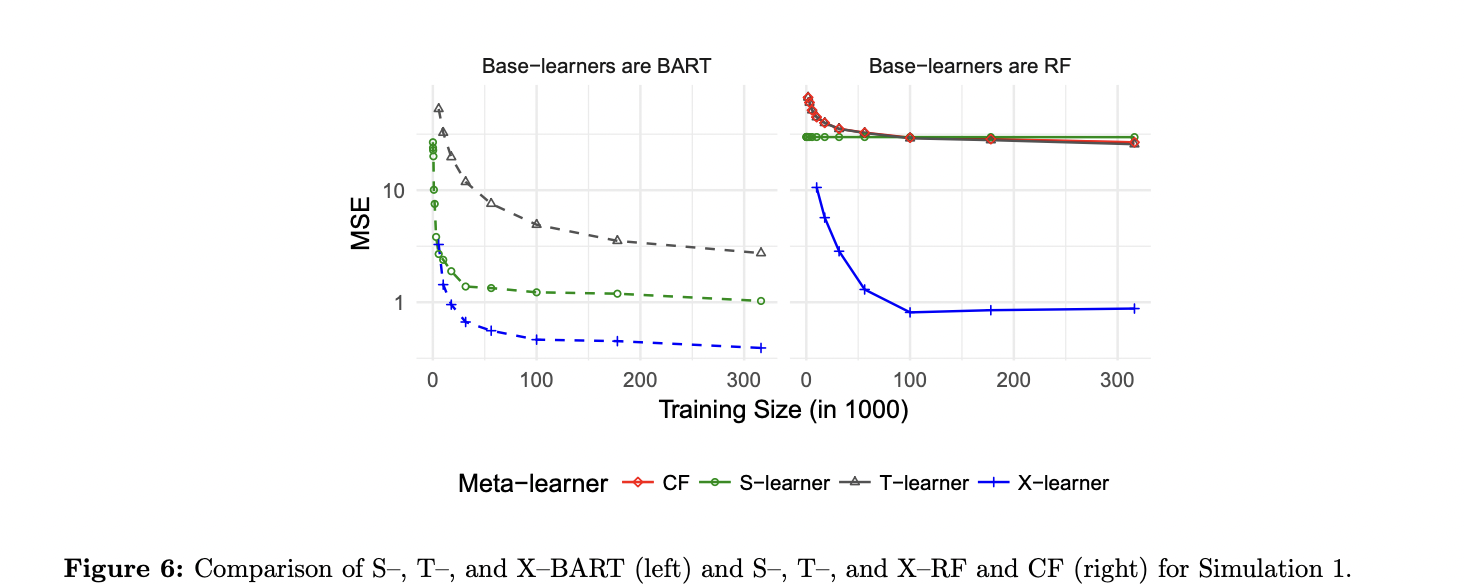

In [7]:
Image("SI_author_results/simA.png", width=800)

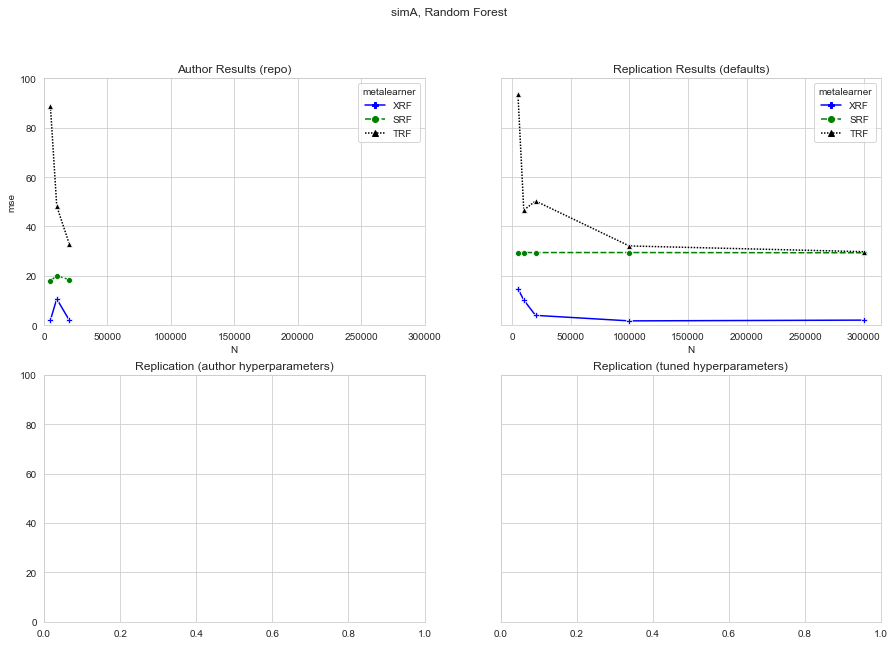

In [8]:
plot_replication_results(sim='simA', base_learner='Random Forest', ymax=100)

# SimB

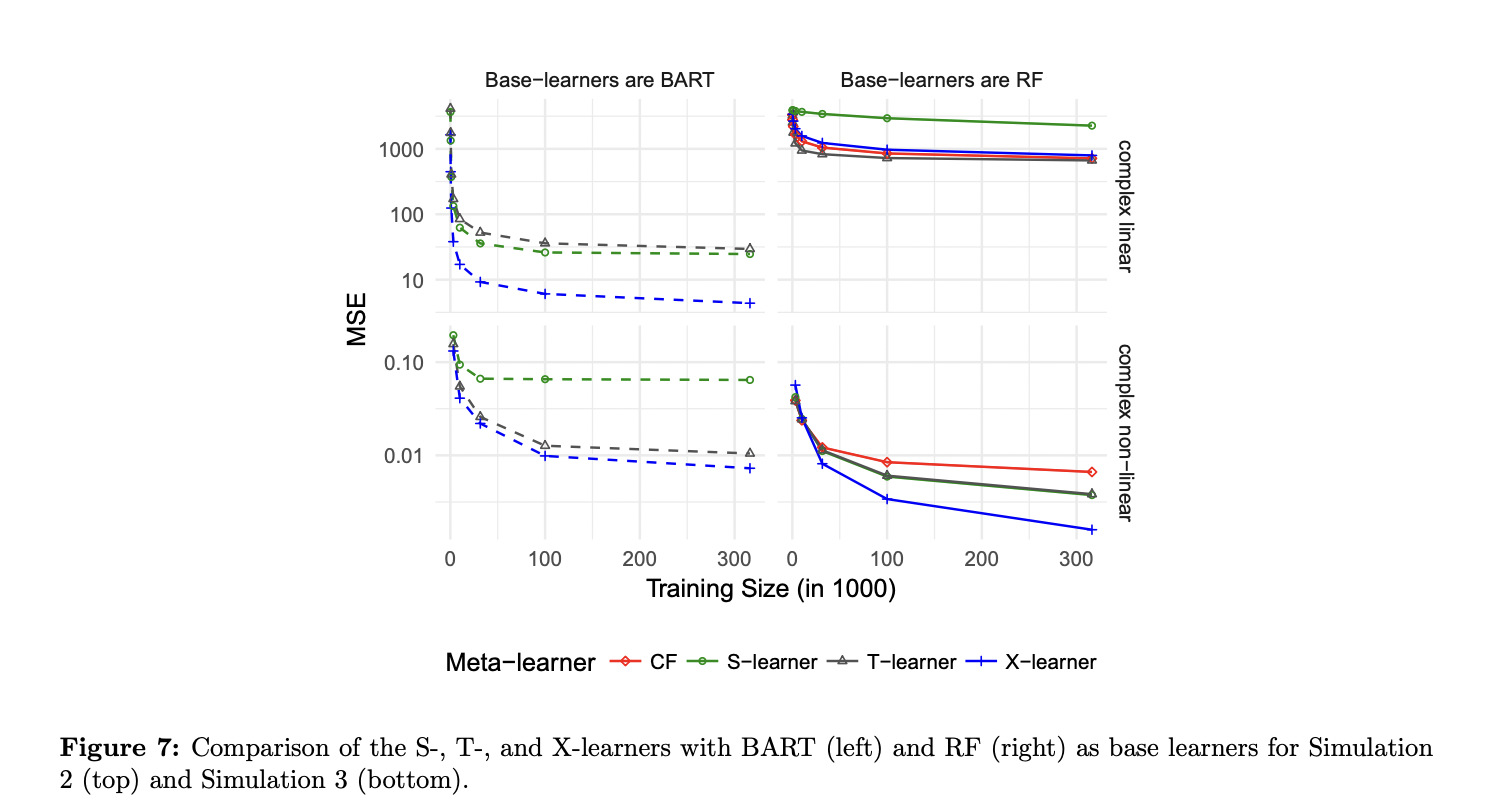

In [9]:
Image("SI_author_results/simB_simC.png", width=800)

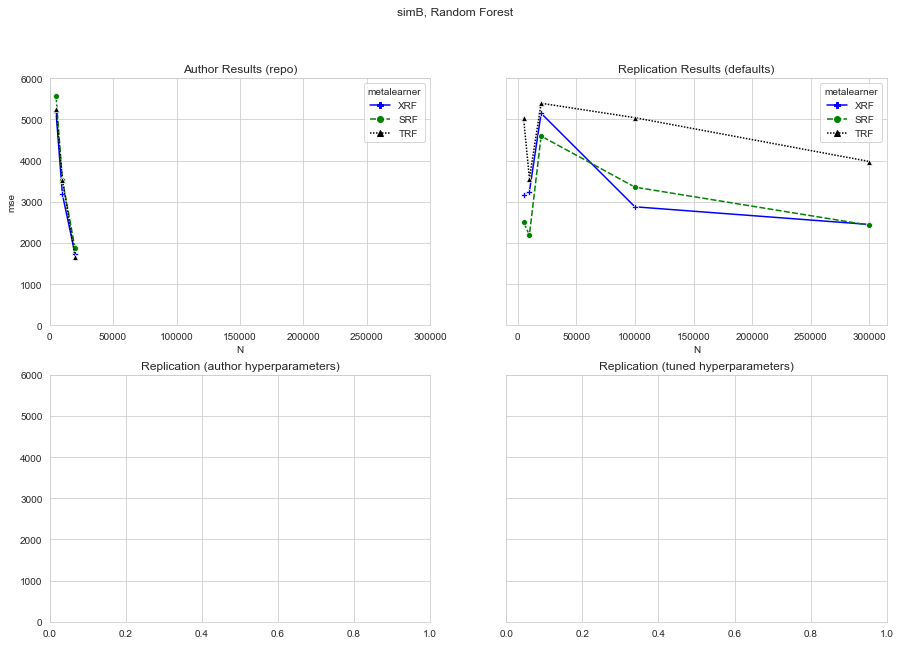

In [10]:
plot_replication_results(sim='simB', base_learner='Random Forest', ymax=6000)

# SimC

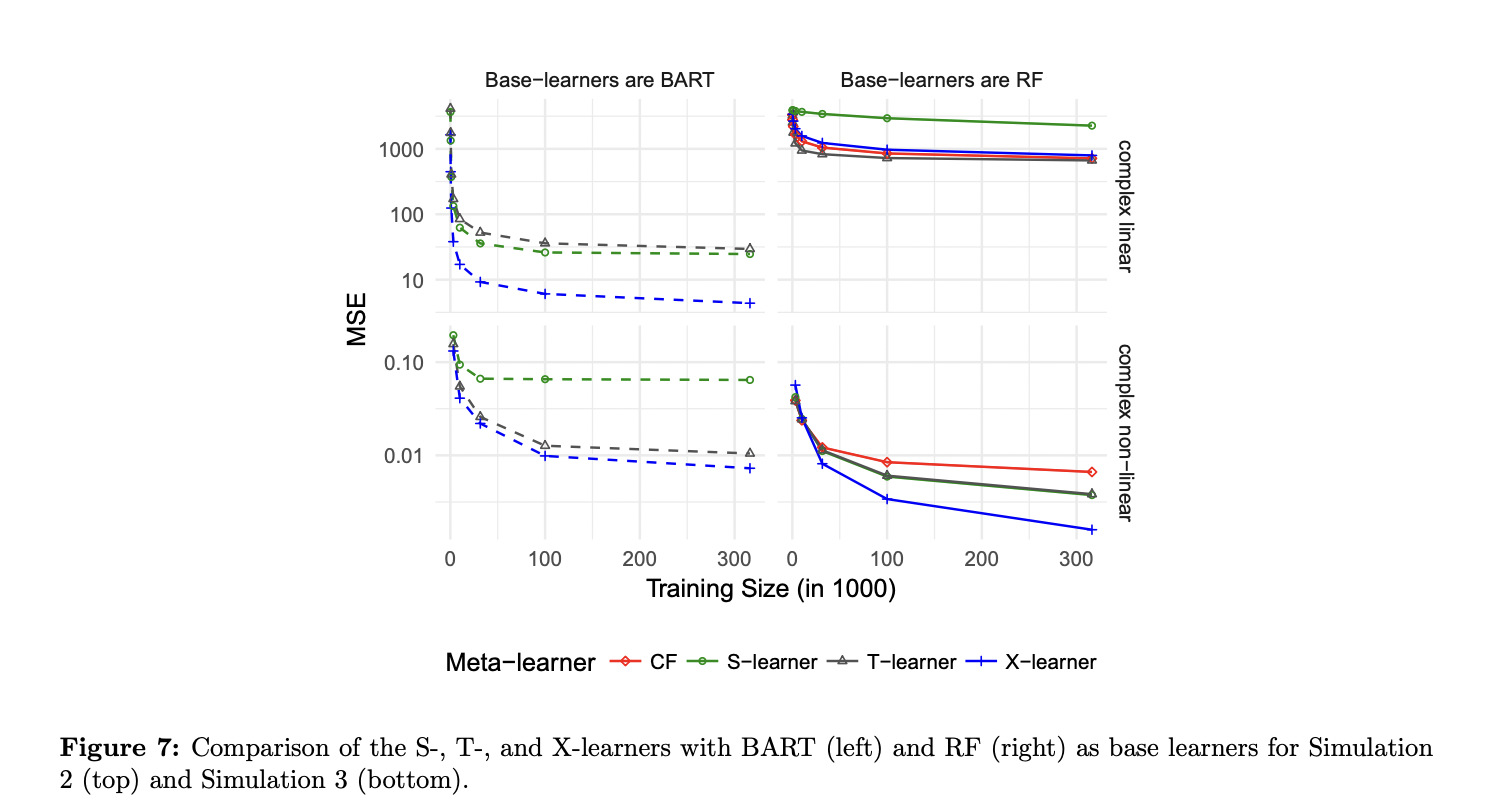

In [11]:
Image("SI_author_results/simB_simC.png", width=800)

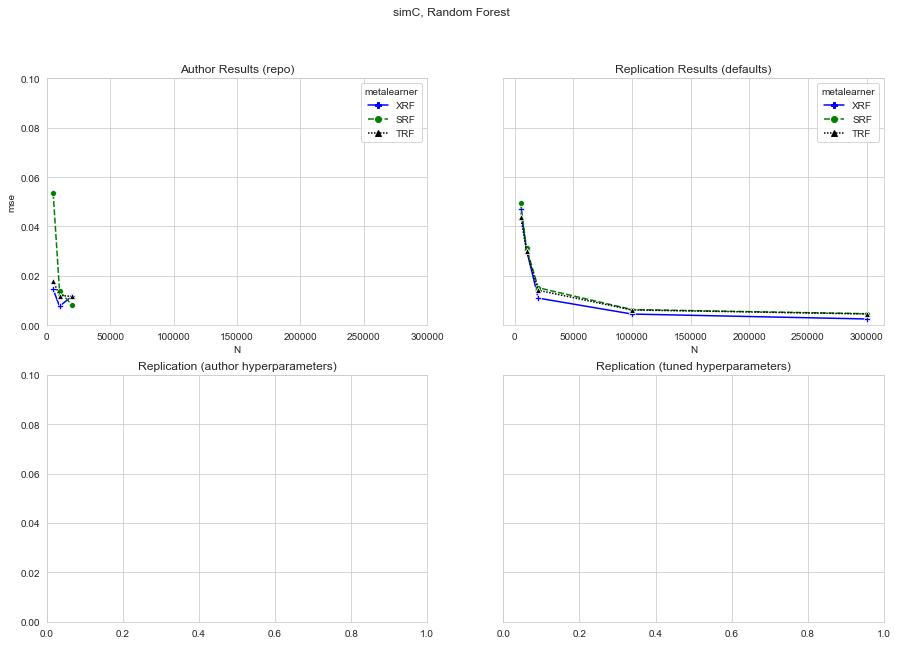

In [12]:
plot_replication_results(sim='simC', base_learner='Random Forest', ymax=0.10)

# Sim D

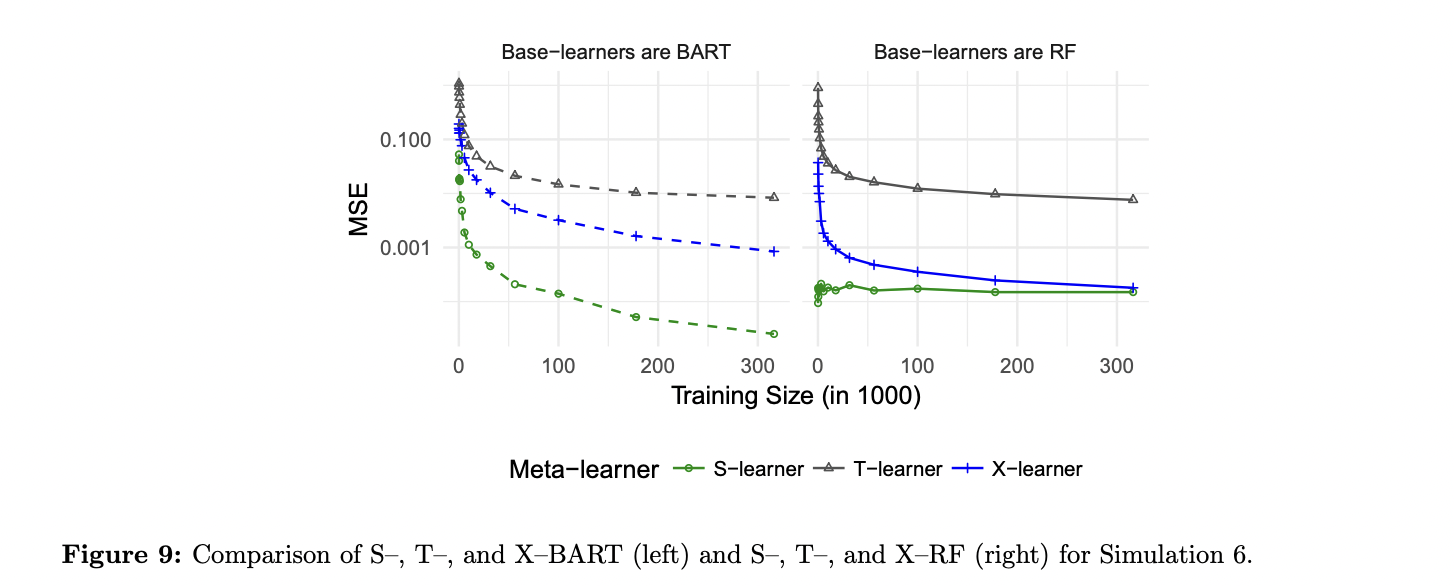

In [13]:
Image("SI_author_results/simD.png", width=800)

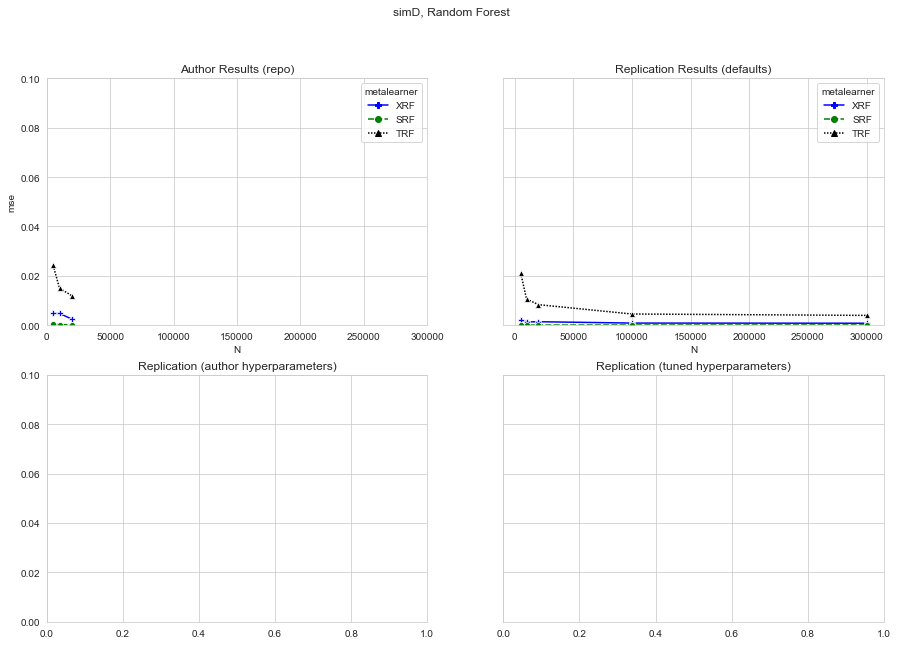

In [14]:
plot_replication_results(sim='simD', base_learner='Random Forest', ymax=0.1)

# New Simulations

# SimE

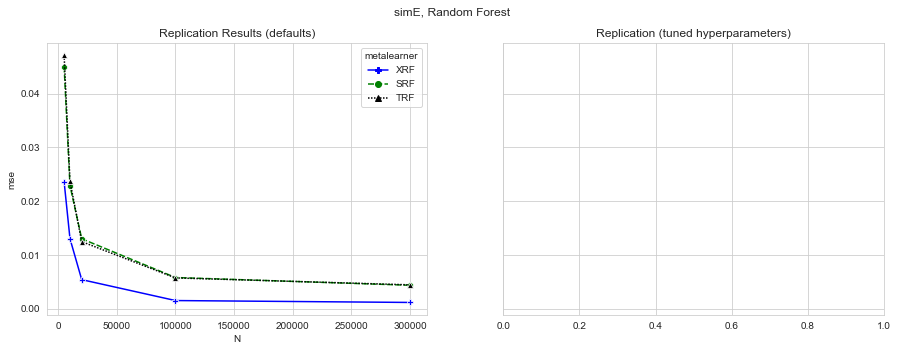

In [15]:
plot_new_sim_results('simE', 'Random Forest')

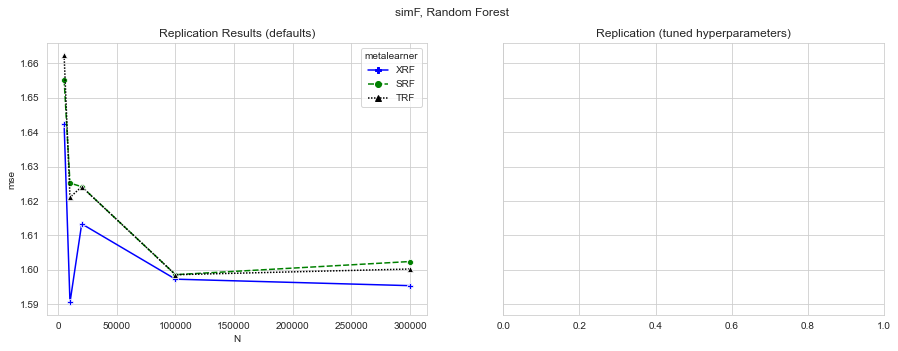

In [16]:
plot_new_sim_results('simF', 'Random Forest')